# Generate dataset for the ML

Goes from labeled original images and crops/resizes/saves them to the production directory

In [6]:
# Python Libraries
import re
from pathlib import Path
import sqlite3
import shutil

# Third-Party Libraries

import matplotlib.pyplot as plt
import pandas as pd

import sys
sys.path.append(str(Path.cwd().parent))

from utils import image_processing

import importlib
importlib.reload(image_processing)

<module 'utils.image_processing' from 'e:\\1C Cursos\\Data Science Part Time - The Bridge\\DS\\Proyecto\\Entregable ML II\\utils\\image_processing.py'>

In [7]:
for file in files:
    try:
        re.findall(r'quality_(.*?)_', file.stem)[0]
    except IndexError:
        print(file)

NameError: name 'files' is not defined

In [8]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())


[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 13072331759938385889
xla_global_id: -1
]


In [9]:
# Create list of all dirs with files
base_dir = Path(Path.cwd().parent.parent, 'data', 'fotocasa')
subdirs = [path for path in base_dir.iterdir() if path.is_dir()]

# Create a list of files, if they have _ in the name means that they've been already labeled
files = [path for subdir in subdirs for path in subdir.iterdir() if (path.is_file()) & ('_' in path.stem) & ('american' not in path.stem)]

# Create List of roomType for each file
roomType = [re.findall(r'_roomType_(.*?)_', file.stem)[0] for file in files]
quality = [re.findall(r'quality_(.*?)_', file.stem)[0] for file in files]

# Create directories for each of the concept
processed_data_dir = Path(Path.cwd().parent, 'data','processed_data')

# Create folder for storing roomType photos
roomType_dir = Path(processed_data_dir, 'roomType')
roomType_dir.mkdir(parents=True, exist_ok=True)

# Create subdirectories based on each category if it doesn't exist
for t in set(roomType):
    Path(roomType_dir, t).mkdir(parents=True, exist_ok=True)

len(files)

3410

In [477]:
# Process and save all the files
for old, rt in zip(files, roomType):
    new = Path(roomType_dir, rt, old.name)
    if not new.is_file():
        image_processing.process_img(old, (128, 128)).save(new)
    # shutil.copy(old, new)

In [10]:
df = pd.DataFrame({'roomType':roomType, 'quality':quality})
df['num'] = 1
df_roomType = df.groupby(by=['roomType']).sum(numeric_only=True).reset_index().copy()
df_grouped = df.groupby(by=['roomType','quality']).sum()#.reset_index()
df_grouped

num
roomType    quality                 
bathroom    high                 162
            homestaging          120
            integral-renovation    8
            luxury                25
            medium               358
bedroom     high                 135
            homestaging          288
            integral-renovation   11
            luxury                 1
            medium               818
kitchen     high                  77
            homestaging          134
            integral-renovation   19
            luxury                 1
            medium               273
living-room high                 163
            homestaging          185
            integral-renovation   22
            luxury                 8
            medium               602

In [11]:
for r in set(roomType):
    for q in set(quality):
        try:
            df_grouped.loc[(r,q), 'num']
        except KeyError:
            df_grouped.loc[(r,q), 'num'] = 0

In [12]:
df_grouped = df_grouped.reset_index()

roomType_list = ['kitchen', 'bathroom', 'living-room', 'bedroom']   # not going to use 'american-kitchen'
quality_list = ['integral-renovation', 'homestaging', 'medium', 'high', 'luxury']


df_grouped['roomType'] = pd.Categorical(df_grouped['roomType'], roomType_list)
df_grouped['quality'] = pd.Categorical(df_grouped['quality'], quality_list)
df_grouped.sort_values(by=['roomType', 'quality'], inplace=True)
df_grouped

,roomType,quality,num
12,kitchen,integral-renovation,19
11,kitchen,homestaging,134
14,kitchen,medium,273
10,kitchen,high,77
13,kitchen,luxury,1
2,bathroom,integral-renovation,8
1,bathroom,homestaging,120
4,bathroom,medium,358
0,bathroom,high,162
3,bathroom,luxury,25


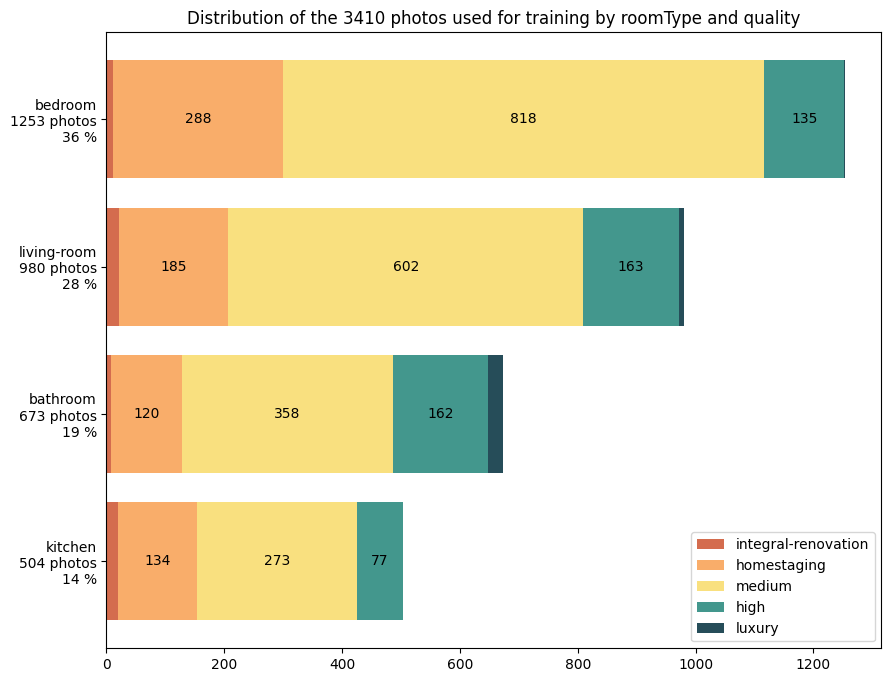

In [15]:
import numpy as np
df_grouped_by_roomType = df.groupby(by='roomType').sum(numeric_only=True)

# I Want to add the totals of each class
groups = [f"{g}\n{df_grouped_by_roomType.loc[g,'num']} photos\n{int(df_grouped_by_roomType.loc[g,'num']/len(files)*100)} %" for g in roomType_list]

quality_0 = df_grouped.loc[df_grouped['quality'] == 'integral-renovation','num'].to_list()
quality_1 = df_grouped.loc[df_grouped['quality'] == 'homestaging','num'].to_list()
quality_2 = df_grouped.loc[df_grouped['quality'] == 'medium','num'].to_list()
quality_3 = df_grouped.loc[df_grouped['quality'] == 'high','num'].to_list()
quality_4 = df_grouped.loc[df_grouped['quality'] == 'luxury','num'].to_list()

values = np.array([quality_0,
                quality_1,
                quality_2,
                quality_3,
                quality_4])

colors = ['#D46C4E', '#F9AD6A', '#F9E07F', '#43978D', '#264D59']

fig, ax = plt.subplots(figsize=(10,8))
for i in range(values.shape[0]):
    bars = ax.barh(groups, values[i], left=np.sum(values[:i], axis = 0), color=colors[i], label=quality_list[i])

for ix, bars in enumerate(ax.containers):
    if (ix == 1) | (ix == 2) | (ix == 3):
        ax.bar_label(bars, label_type='center')

ax.set_title(f'Distribution of the {len(files)} photos used for training by roomType and quality')
# ax.set_xlim([0,1500])
plt.legend()
plt.show()


# Prepare Data to be renamed by ML Model

In [461]:
# Create list of all dirs with files
base_dir = Path(Path.cwd().parent.parent, 'data', 'fotocasa', 'AUTO')
subdirs = [path for path in base_dir.iterdir() if path.is_dir()]

# Create a list of files, if they have _ in the name means that they've been already labeled
files = [path for subdir in subdirs for path in subdir.iterdir() if (path.is_file())]

len(files)

3817

In [462]:
files

[WindowsPath('e:/1C Cursos/Data Science Part Time - The Bridge/DS/Proyecto/data/fotocasa/AUTO/164354362/504023665.jpg'),
 WindowsPath('e:/1C Cursos/Data Science Part Time - The Bridge/DS/Proyecto/data/fotocasa/AUTO/164354362/504023706.jpg'),
 WindowsPath('e:/1C Cursos/Data Science Part Time - The Bridge/DS/Proyecto/data/fotocasa/AUTO/164354362/504023725.jpg'),
 WindowsPath('e:/1C Cursos/Data Science Part Time - The Bridge/DS/Proyecto/data/fotocasa/AUTO/164354362/504023732.jpg'),
 WindowsPath('e:/1C Cursos/Data Science Part Time - The Bridge/DS/Proyecto/data/fotocasa/AUTO/164354362/504023761.jpg'),
 WindowsPath('e:/1C Cursos/Data Science Part Time - The Bridge/DS/Proyecto/data/fotocasa/AUTO/164354362/504023792.jpg'),
 WindowsPath('e:/1C Cursos/Data Science Part Time - The Bridge/DS/Proyecto/data/fotocasa/AUTO/164354362/504023828.jpg'),
 WindowsPath('e:/1C Cursos/Data Science Part Time - The Bridge/DS/Proyecto/data/fotocasa/AUTO/164354362/504023869.jpg'),
 WindowsPath('e:/1C Cursos/Data 